<a href="https://colab.research.google.com/github/its-Nhi-Ho/DS102__P.21/blob/master/BTTH5_Gausssian_Mixture_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.weights = None  # Trọng số hỗn hợp (pi_k)
        self.means = None    # Trung bình (mu_k)
        self.covariances = None # Ma trận hiệp phương sai (Sigma_k)
        self.log_likelihood_history = []

    def _multivariate_gaussian_pdf(self, X, mean, cov):
        n_features = X.shape[1]

        cov_for_cholesky = cov + np.eye(n_features) * self.reg_covar

        try:
            L = np.linalg.cholesky(cov_for_cholesky)
        except np.linalg.LinAlgError:
            print(f"Cảnh báo: Phân rã Cholesky thất bại. Ma trận hiệp phương sai có thể không xác định dương. Đang tăng giá trị regularization lên {self.reg_covar * 10}.")
            cov_for_cholesky = cov + np.eye(n_features) * (self.reg_covar * 10)
            try:
                L = np.linalg.cholesky(cov_for_cholesky)
            except np.linalg.LinAlgError:
                raise ValueError("Phân rã Cholesky thất bại ngay cả sau khi tăng regularization. Hãy kiểm tra dữ liệu hoặc ma trận hiệp phương sai ban đầu.")

        det_cov = np.prod(np.diagonal(L))**2

        X_centered = X - mean

        z = np.linalg.solve(L, X_centered.T).T

        exponent = -0.5 * np.sum(z**2, axis=1)

        norm_const = 1.0 / np.sqrt((2 * np.pi)**n_features * det_cov)

        return norm_const * np.exp(exponent)

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape

        # Khởi tạo trọng số hỗn hợp đồng đều
        self.weights = np.ones(self.n_components) / self.n_components

        # Khởi tạo trung bình bằng cách chọn ngẫu nhiên các điểm dữ liệu làm tâm
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]

        # Khởi tạo ma trận hiệp phương sai là ma trận đơn vị
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

    def _calculate_log_likelihood(self, X, responsibilities, sum_responsibilities_per_sample):
        # Tránh log(0) bằng cách thêm một lượng epsilon nhỏ
        return np.sum(np.log(sum_responsibilities_per_sample + 1e-300))


    def fit(self, X):
        n_samples, n_features = X.shape
        self._initialize_parameters(X)
        prev_log_likelihood = -np.inf

        print("Bắt đầu huấn luyện GMM (thuật toán EM)...")
        for iteration in range(self.max_iter):
            # E-step (Expectation)
            cluster_pdfs = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                cluster_pdfs[:, k] = self._multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

            weighted_pdfs = self.weights * cluster_pdfs
            sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)
            responsibilities = weighted_pdfs / (sum_weighted_pdfs + 1e-300)

            # M-step (Maximization)
            N_k = np.sum(responsibilities, axis=0)

            for k in range(self.n_components):
                # Cập nhật trung bình
                self.means[k] = np.sum(responsibilities[:, k, np.newaxis] * X, axis=0) / (N_k[k] + 1e-300)

                # Cập nhật ma trận hiệp phương sai (sửa đổi theo cách của bạn)
                diff = X - self.means[k]
                # Trọng số của từng điểm dữ liệu cho cluster k
                weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
                # Tính tổng có trọng số của outer product (x_n - mu_k)(x_n - mu_k)^T
                # weighted_diff.T có shape (n_features, n_samples)
                # diff có shape (n_samples, n_features)
                self.covariances[k] = (weighted_diff.T @ diff) / (N_k[k] + 1e-300)

                # Thêm regularization trực tiếp vào ma trận hiệp phương sai sau khi cập nhật
                self.covariances[k] += np.eye(n_features) * self.reg_covar

            self.weights = N_k / (n_samples + 1e-300)

            current_log_likelihood = self._calculate_log_likelihood(X, responsibilities, sum_weighted_pdfs)
            self.log_likelihood_history.append(current_log_likelihood)

            print(f"Lần lặp {iteration+1}/{self.max_iter}")

            if iteration > 0 and np.abs(current_log_likelihood - prev_log_likelihood) < self.tol:
                print(f"GMM đã hội tụ ở lần lặp {iteration+1}")
                break
            prev_log_likelihood = current_log_likelihood
        print("Quá trình huấn luyện GMM đã hoàn tất.")

    def predict_proba(self, X):
        n_samples = X.shape[0]
        cluster_pdfs = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            cluster_pdfs[:, k] = self._multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])

        weighted_pdfs = self.weights * cluster_pdfs
        sum_weighted_pdfs = np.sum(weighted_pdfs, axis=1, keepdims=True)

        # Thêm epsilon để tránh chia cho 0
        return weighted_pdfs / (sum_weighted_pdfs + 1e-300)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def remove_background_with_gmm(image_path, gmm_model, display=True):
    # Đọc và xử lý ảnh
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    H, W, C = img_array.shape

    # Chuẩn hóa màu RGB
    X_rgb = img_array.reshape(-1, 3) / 255.0

    # Chuẩn hóa vị trí (tọa độ pixel)
    x_coords, y_coords = np.meshgrid(np.arange(W), np.arange(H))
    X_pos = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2) / max(H, W)

    # Tập đặc trưng: màu + vị trí
    X = np.concatenate([X_rgb, X_pos], axis=1)

    # Huấn luyện GMM
    gmm_model.fit(X)
    labels = gmm_model.predict(X)

    # Xác định nhãn của nền là cụm lớn nhất
    (unique, counts) = np.unique(labels, return_counts=True)
    bg_label = unique[np.argmax(counts)]

    # Tạo ảnh có alpha channel (RGBA)
    foreground = img_array.reshape(-1, 3).copy()
    alpha_channel = np.ones((H * W,), dtype=np.uint8) * 255
    alpha_channel[labels == bg_label] = 0  # nền → trong suốt

    rgba_img = np.concatenate([
        foreground,                     # RGB
        alpha_channel[:, np.newaxis]   # Alpha
    ], axis=1).reshape(H, W, 4)

    result_img = Image.fromarray(rgba_img.astype(np.uint8), mode='RGBA')

    if display:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Ảnh gốc")
        plt.imshow(img_array)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Nền trong suốt")
        plt.imshow(result_img)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return result_img, labels.reshape(H, W)


In [15]:
from google.colab import files
uploaded = files.upload()

Saving cow.jpg to cow (1).jpg


In [6]:
!pip install opencv-python

Bắt đầu huấn luyện GMM (thuật toán EM)...
Lần lặp 1/100
Lần lặp 2/100
Lần lặp 3/100
Lần lặp 4/100
Lần lặp 5/100
Lần lặp 6/100
Lần lặp 7/100
Lần lặp 8/100
Lần lặp 9/100
Lần lặp 10/100
Lần lặp 11/100
Lần lặp 12/100
Lần lặp 13/100
Lần lặp 14/100
Lần lặp 15/100
Lần lặp 16/100
Lần lặp 17/100
Lần lặp 18/100
Lần lặp 19/100
Lần lặp 20/100
Lần lặp 21/100
Lần lặp 22/100
Lần lặp 23/100
Lần lặp 24/100
Lần lặp 25/100
Lần lặp 26/100
Lần lặp 27/100
Lần lặp 28/100
Lần lặp 29/100
Lần lặp 30/100
GMM đã hội tụ ở lần lặp 30
Quá trình huấn luyện GMM đã hoàn tất.


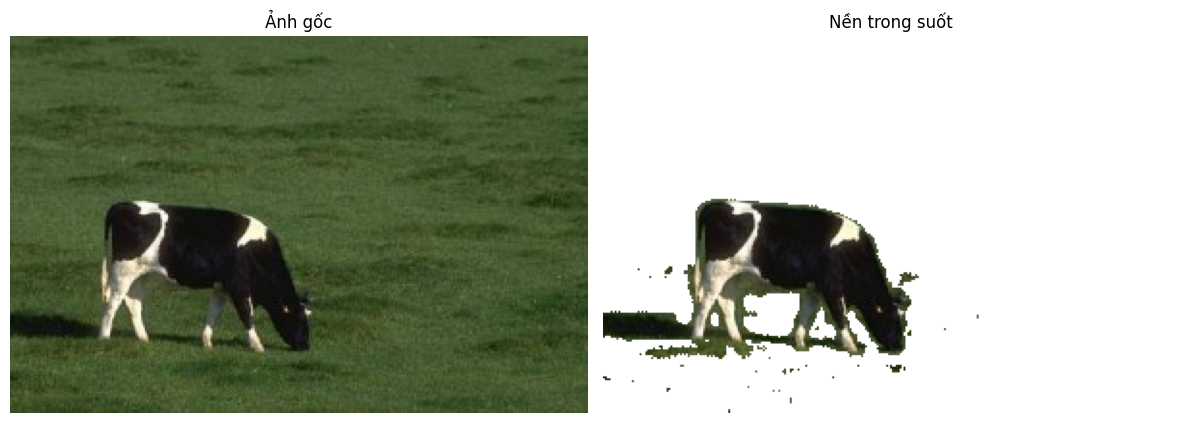

In [25]:
gmm = GMM(n_components=2)
result_img, pixel_labels = remove_background_with_gmm("cow.jpg", gmm)

In [34]:
result_img.save("cow_transparent1.png")

In [26]:
import numpy as np
from PIL import Image
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

def remove_background_with_transparency(image_path, n_components=3, save_path="output.png", display=True):
    # Đọc ảnh và chuyển về RGB
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    H, W, C = img_np.shape

    # Chuẩn bị dữ liệu đầu vào cho GMM (chỉ RGB)
    X = img_np.reshape(-1, 3)

    # Áp dụng GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='tied', random_state=0)
    gmm.fit(X)
    labels = gmm.predict(X)

    # Xác định nền là cụm lớn nhất
    unique, counts = np.unique(labels, return_counts=True)
    bg_label = unique[np.argmax(counts)]

    # Tạo ảnh RGBA (có kênh alpha)
    rgba = np.concatenate([img_np.reshape(-1, 3), np.ones((H * W, 1)) * 255], axis=1)  # alpha mặc định = 255
    rgba[labels == bg_label, 3] = 0  # đặt alpha = 0 cho nền (trong suốt)

    rgba = rgba.reshape(H, W, 4).astype(np.uint8)
    transparent_img = Image.fromarray(rgba, 'RGBA')

    # Lưu ảnh
    transparent_img.save(save_path)

    # Hiển thị nếu cần
    if display:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.title("Nền gốc")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Nền trong suốt")
        plt.imshow(transparent_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return transparent_img

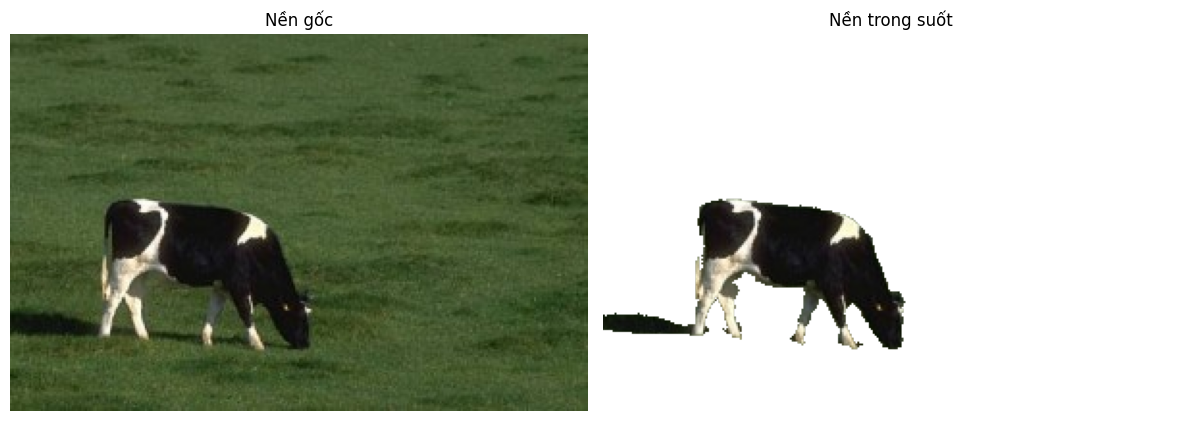

In [32]:
# Gọi hàm
result_img_sk = remove_background_with_transparency("cow.jpg", n_components=3)

# Lưu ảnh có nền trong suốt
result_img_sk.save("cow_transparent.png")
